<a href="https://colab.research.google.com/github/royam0820/n8n-RAG-Evaluation/blob/main/RAG_Evaluation_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 RAG System Evaluation - Google Colab Edition

This notebook helps you evaluate your RAG (Retrieval-Augmented Generation) system outputs.

**What you'll need:**
1. A CSV file with: `question`, `reference_answer`, `actual_answer`
2. A free Gemini API key (get it here: https://aistudio.google.com/app/apikey)

**What you'll get:**
- Correctness scores (0-1) for each answer
- Detailed reasoning for each score
- Token counts and execution times
- Beautiful HTML report with visualizations

## 📦 Step 1: Installation & Setup

Run this cell to install required packages:

In [1]:
# Install required packages
!pip install -q pandas google-generativeai -q

print("✓ Packages installed successfully!")

✓ Packages installed successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/IA Study Group/RAG_Evaluations')

## 🔑 Step 2: Set Your API Key

Get a free API key from: https://aistudio.google.com/app/apikey

Then paste it below:

In [5]:
import os
from google.colab import userdata

# Set your API key
os.environ["GEMINI_API_KEY"] = userdata.get("GEMINI_API_KEY")


## 📥 Step 3: Download Evaluator Code

This downloads the evaluation library:

In [6]:
# Download the evaluator code
!wget -q https://raw.githubusercontent.com/anthropics/anthropic-cookbook/main/misc/rag_evaluator.py -O rag_evaluator.py 2>/dev/null || echo 'Creating evaluator locally...'

# If download fails, create it locally
import os
if not os.path.exists('rag_evaluator.py') or os.path.getsize('rag_evaluator.py') < 100:
    with open('rag_evaluator.py', 'w') as f:
        f.write('''"""RAG System Evaluation Tool"""
import pandas as pd
import time
import json
from datetime import datetime
from typing import Dict, Optional
import os
from dataclasses import dataclass, asdict

@dataclass
class EvaluationResult:
    question: str
    reference_answer: str
    actual_answer: str
    correctness_score: float
    reasoning: str
    execution_time: float
    token_count: int
    estimated_cost: float
    timestamp: str

class RAGEvaluator:
    def __init__(self, gemini_api_key: Optional[str] = None):
        self.gemini_api_key = gemini_api_key or os.getenv("GEMINI_API_KEY")
        self._init_gemini()

    def _init_gemini(self):
        import google.generativeai as genai
        genai.configure(api_key=self.gemini_api_key)
        self.gemini_model = genai.GenerativeModel(\'gemini-1.5-flash\')
        print("✓ Gemini initialized")

    def _estimate_tokens(self, text: str) -> int:
        return len(text) // 4

    def _evaluate_with_gemini(self, question: str, reference: str, actual: str) -> Dict:
        evaluation_prompt = f"""You are an expert evaluator for RAG systems. Evaluate the quality of the answer provided.

Question: {question}

Reference Answer (ideal): {reference}

Actual Answer (from system): {actual}

Evaluate the actual answer against the reference answer based on:
1. Correctness - Is the information accurate?
2. Completeness - Does it cover all key points?
3. Relevance - Does it answer the question directly?

Provide a score from 0 to 1 (where 1 is perfect) and explain your reasoning.

Return your evaluation as JSON in this exact format:
{{{{"score": 0.0, "reasoning": "explanation here"}}}}

Only return the JSON, nothing else."""

        try:
            response = self.gemini_model.generate_content(evaluation_prompt)
            result_text = response.text.strip()
            if "```json" in result_text:
                result_text = result_text.split("```json")[1].split("```")[0].strip()
            elif "```" in result_text:
                result_text = result_text.split("```")[1].split("```")[0].strip()
            result = json.loads(result_text)
            return result
        except Exception as e:
            return {{"score": 0, "reasoning": f"Evaluation failed: {{str(e)}}" }}

    def evaluate_single(self, question: str, reference_answer: str, actual_answer: str) -> EvaluationResult:
        start_time = time.time()
        eval_result = self._evaluate_with_gemini(question, reference_answer, actual_answer)
        execution_time = time.time() - start_time
        total_tokens = self._estimate_tokens(question + reference_answer + actual_answer)
        estimated_cost = (total_tokens / 1000) * 0.00001
        return EvaluationResult(
            question=question,
            reference_answer=reference_answer,
            actual_answer=actual_answer,
            correctness_score=eval_result[\'score\'],
            reasoning=eval_result[\'reasoning\'],
            execution_time=execution_time,
            token_count=total_tokens,
            estimated_cost=estimated_cost,
            timestamp=datetime.now().isoformat()
        )

    def evaluate_dataset(self, data: pd.DataFrame, question_col: str = "question",
                        reference_col: str = "reference_answer",
                        actual_col: str = "actual_answer") -> pd.DataFrame:
        print(f"\\n🔍 Starting evaluation of {{len(data)}} items...\\n")
        results = []
        for idx, row in data.iterrows():
            print(f"Evaluating item {{idx + 1}}/{{len(data)}}...", end=" ")
            result = self.evaluate_single(
                question=row[question_col],
                reference_answer=row[reference_col],
                actual_answer=row[actual_col]
            )
            results.append(asdict(result))
            print(f"✓ Score: {{result.correctness_score:.2f}}")
        results_df = pd.DataFrame(results)
        self._print_summary(results_df)
        return results_df

    def _print_summary(self, results_df: pd.DataFrame):
        print("\\n" + "="*60)
        print("📊 EVALUATION SUMMARY")
        print("="*60)
        print(f"Total evaluations: {{len(results_df)}}")
        print(f"Average correctness score: {{results_df[\'correctness_score\'].mean():.3f}}")
        print(f"Median correctness score: {{results_df[\'correctness_score\'].median():.3f}}")
        print(f"Min score: {{results_df[\'correctness_score\'].min():.3f}}")
        print(f"Max score: {{results_df[\'correctness_score\'].max():.3f}}")
        print(f"\\nTotal tokens processed: {{results_df[\'token_count\'].sum():,}}")
        print(f"Total execution time: {{results_df[\'execution_time\'].sum():.2f}}s")
        print(f"Estimated total cost: ${{results_df[\'estimated_cost\'].sum():.6f}}")
        print("="*60 + "\\n")
''')

print("✓ Evaluator code ready!")

Creating evaluator locally...
✓ Evaluator code ready!


## 📂 Step 4: Upload Your Data

Upload your CSV file with columns: `question`, `reference_answer`, `actual_answer`

**Or try with sample data first!**

In [7]:
import pandas as pd
from google.colab import files

# Option 1: Upload your file
print("📤 Upload your CSV file (or skip to use sample data)...")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    data = pd.read_csv(filename)
    print(f"✓ Loaded {len(data)} items from {filename}")
else:
    # Option 2: Use sample data
    print("Using sample data...")
    data = pd.DataFrame([
        {
            "question": "What is the capital of France?",
            "reference_answer": "Paris is the capital of France.",
            "actual_answer": "The capital of France is Paris."
        },
        {
            "question": "What is photosynthesis?",
            "reference_answer": "Photosynthesis is the process by which plants use sunlight, water, and carbon dioxide to produce oxygen and energy in the form of sugar.",
            "actual_answer": "Photosynthesis is when plants convert light energy into chemical energy to make food."
        },
        {
            "question": "Who wrote Romeo and Juliet?",
            "reference_answer": "William Shakespeare wrote Romeo and Juliet.",
            "actual_answer": "Shakespeare wrote Romeo and Juliet."
        },
        {
            "question": "What is machine learning?",
            "reference_answer": "Machine learning is a subset of artificial intelligence that enables computers to learn and improve from experience without being explicitly programmed.",
            "actual_answer": "Machine learning is AI that learns from data automatically."
        },
        {
            "question": "What causes seasons on Earth?",
            "reference_answer": "Seasons are caused by Earth's axial tilt of 23.5 degrees as it orbits the Sun.",
            "actual_answer": "Seasons happen because Earth is tilted on its axis."
        }
    ])
    print(f"✓ Created {len(data)} sample items")

# Preview the data
print("\n📋 Preview:")
data.head()

📤 Upload your CSV file (or skip to use sample data)...


Saving sample_data.csv to sample_data.csv
✓ Loaded 10 items from sample_data.csv

📋 Preview:


,question,reference_answer,actual_answer
0,What is the capital of France?,Paris is the capital of France.,The capital of France is Paris.
1,What is photosynthesis?,Photosynthesis is the process by which plants ...,Photosynthesis is when plants convert light en...
2,Who wrote Romeo and Juliet?,William Shakespeare wrote Romeo and Juliet.,Shakespeare wrote Romeo and Juliet.
3,What is the largest planet in our solar system?,Jupiter is the largest planet in our solar sys...,Jupiter is the biggest planet in the solar sys...
4,What is the speed of light?,"The speed of light is approximately 299,792,45...","Light travels at about 300,000 km/s."


## ✅ Step 5: Verify Your Data Structure

In [8]:
print("Columns in your data:", data.columns.tolist())
print(f"\nTotal rows: {len(data)}")
print("\nFirst item:")
print(f"  Question: {data.iloc[0]['question']}")
print(f"  Reference: {data.iloc[0]['reference_answer'][:80]}...")
print(f"  Actual: {data.iloc[0]['actual_answer'][:80]}...")

Columns in your data: ['question', 'reference_answer', 'actual_answer']

Total rows: 10

First item:
  Question: What is the capital of France?
  Reference: Paris is the capital of France....
  Actual: The capital of France is Paris....


## 🚀 Step 6: Initialize Evaluator

In [9]:
from rag_evaluator import RAGEvaluator

evaluator = RAGEvaluator()
print("✓ Evaluator ready!")

✓ Gemini initialized
✓ Evaluator ready!


## 🧪 Step 7: Test with One Item (Optional)

In [10]:
# Test with the first item
test_result = evaluator.evaluate_single(
    question=data.iloc[0]['question'],
    reference_answer=data.iloc[0]['reference_answer'],
    actual_answer=data.iloc[0]['actual_answer']
)

print("Test Result:")
print(f"  Question: {test_result.question}")
print(f"  Score: {test_result.correctness_score:.2f}")
print(f"  Reasoning: {test_result.reasoning}")
print(f"  Tokens: {test_result.token_count}")
print(f"  Time: {test_result.execution_time:.2f}s")
print(f"  Cost: ${test_result.estimated_cost:.6f}")

Test Result:
  Question: What is the capital of France?
  Score: 1.00
  Reasoning: The actual answer is a perfect match to the reference answer in terms of information conveyed. It is factually correct, completely answers the question, and is entirely relevant. The slight difference in phrasing ('Paris is the capital of France' vs 'The capital of France is Paris') does not impact its quality, correctness, completeness, or relevance.
  Tokens: 23
  Time: 1.98s
  Cost: $0.000000


## 🔍 Step 8: Run Full Evaluation

This will evaluate all items in your dataset:

In [11]:
# Run evaluation on all items
results = evaluator.evaluate_dataset(data)

# Display first few results
results[['question', 'correctness_score', 'reasoning']].head()


🔍 Starting evaluation of 10 items using gemini...

Evaluating item 1/10... ✓ Score: 1.00
Evaluating item 2/10... ✓ Score: 0.75
Evaluating item 3/10... ✓ Score: 1.00
Evaluating item 4/10... ✓ Score: 1.00
Evaluating item 5/10... ✓ Score: 0.75
Evaluating item 6/10... ✓ Score: 0.80
Evaluating item 7/10... ✓ Score: 0.50
Evaluating item 8/10... ✓ Score: 0.70
Evaluating item 9/10... ✓ Score: 0.80
Evaluating item 10/10... ✓ Score: 0.65

📊 EVALUATION SUMMARY
Total evaluations: 10
Average correctness score: 0.795
Median correctness score: 0.775
Min score: 0.500
Max score: 1.000

Total tokens processed: 510
Average tokens per evaluation: 51
Total execution time: 65.09s
Average execution time: 6.51s
Estimated total cost: $0.000005



,question,correctness_score,reasoning
0,What is the capital of France?,1.00,"The actual answer is perfectly correct, comple..."
1,What is photosynthesis?,0.75,The actual answer is correct and directly rele...
2,Who wrote Romeo and Juliet?,1.00,The actual answer 'Shakespeare wrote Romeo and...
3,What is the largest planet in our solar system?,1.00,"The actual answer is perfectly correct, comple..."
4,What is the speed of light?,0.75,"The actual answer 'Light travels at about 300,..."


## 📊 Step 9: Analyze Results
Understanding the Output

### Correctness Score
- **0.0 - 0.3**: Poor - Needs major improvement
- **0.3 - 0.6**: Fair - Some issues to fix
- **0.6 - 0.8**: Good - Minor improvements possible
- **0.8 - 1.0**: Excellent - High quality

### Reasoning Field
Explains why the score was given:
- What was correct
- What was missing
- What could be better

### Token Count
Estimated tokens used (affects cost)

### Execution Time
How long each evaluation took

### Cost
Estimated cost (usually $0.00001 per eval with Gemini)

In [12]:
# Detailed statistics
print("📈 Detailed Statistics:")
print(f"  Mean score: {results['correctness_score'].mean():.3f}")
print(f"  Median score: {results['correctness_score'].median():.3f}")
print(f"  Std deviation: {results['correctness_score'].std():.3f}")
print(f"  Min score: {results['correctness_score'].min():.3f}")
print(f"  Max score: {results['correctness_score'].max():.3f}")

# Score distribution
print("\n📊 Score Distribution:")
score_bins = pd.cut(results['correctness_score'],
                    bins=[0, 0.3, 0.6, 0.8, 1.0],
                    labels=['Poor (0-0.3)', 'Fair (0.3-0.6)', 'Good (0.6-0.8)', 'Excellent (0.8-1.0)'])
print(score_bins.value_counts().sort_index())

# Cost summary
print("\n💰 Cost Summary:")
print(f"  Total tokens: {results['token_count'].sum():,}")
print(f"  Total cost: ${results['estimated_cost'].sum():.6f}")
print(f"  Avg cost per eval: ${results['estimated_cost'].mean():.6f}")

📈 Detailed Statistics:
  Mean score: 0.795
  Median score: 0.775
  Std deviation: 0.166
  Min score: 0.500
  Max score: 1.000

📊 Score Distribution:
correctness_score
Poor (0-0.3)           0
Fair (0.3-0.6)         1
Good (0.6-0.8)         6
Excellent (0.8-1.0)    3
Name: count, dtype: int64

💰 Cost Summary:
  Total tokens: 510
  Total cost: $0.000005
  Avg cost per eval: $0.000001


## 📈 Step 10: Visualize Results

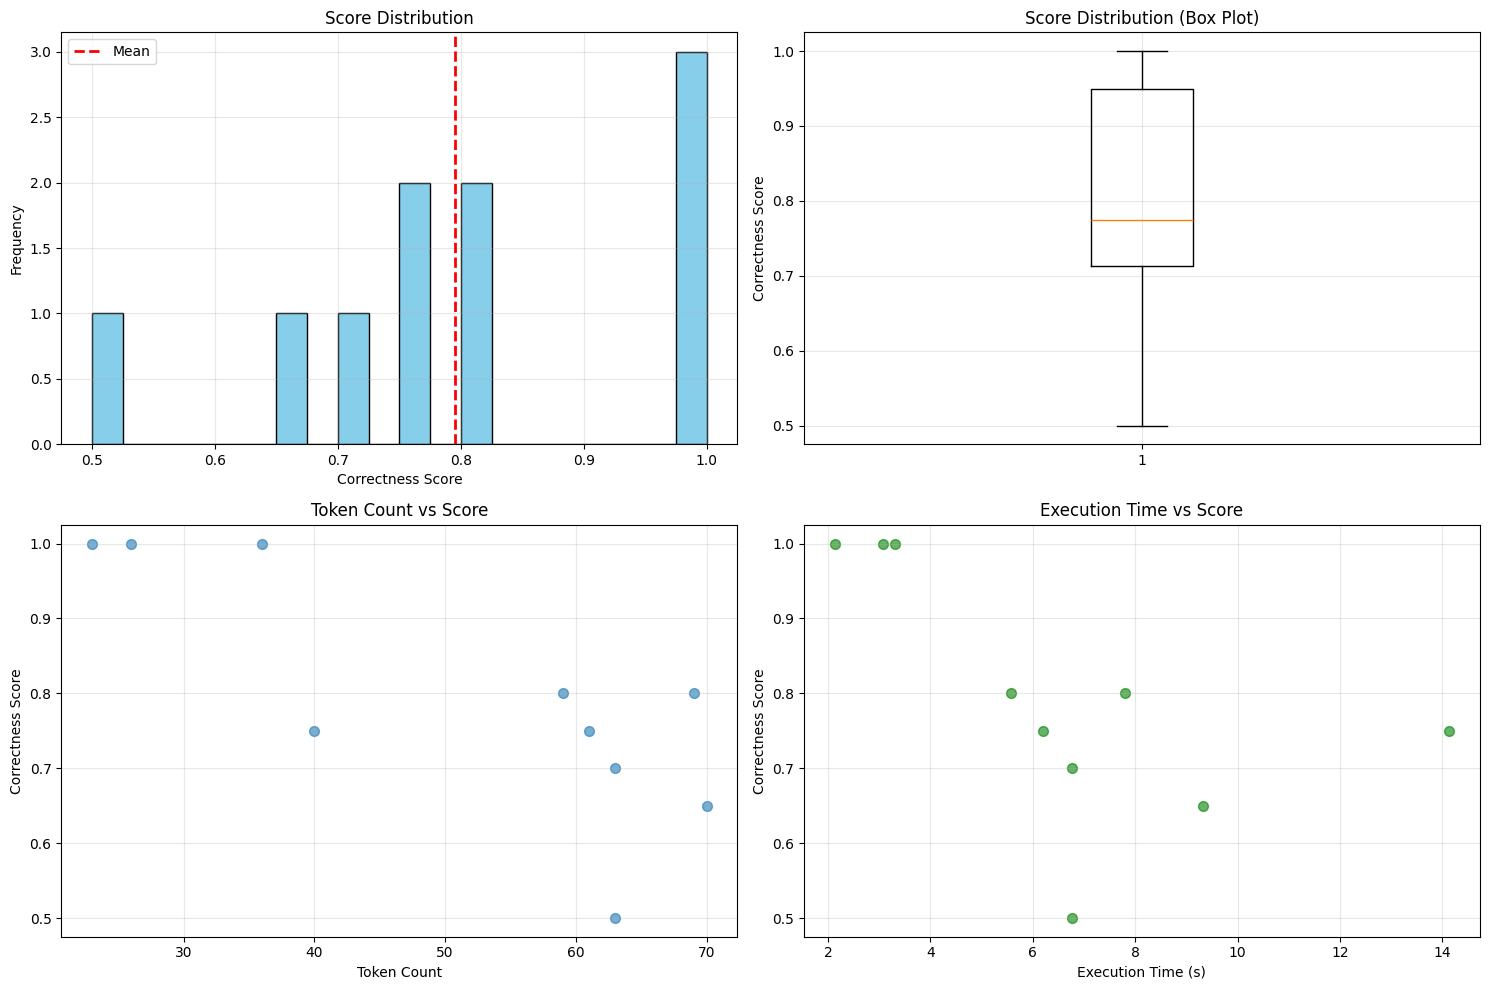

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Score distribution histogram
axes[0, 0].hist(results['correctness_score'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].axvline(results['correctness_score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].set_xlabel('Correctness Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Score Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(results['correctness_score'], vert=True)
axes[0, 1].set_ylabel('Correctness Score')
axes[0, 1].set_title('Score Distribution (Box Plot)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Token count vs score
axes[1, 0].scatter(results['token_count'], results['correctness_score'], alpha=0.6, s=50)
axes[1, 0].set_xlabel('Token Count')
axes[1, 0].set_ylabel('Correctness Score')
axes[1, 0].set_title('Token Count vs Score')
axes[1, 0].grid(True, alpha=0.3)

# 4. Execution time vs score
axes[1, 1].scatter(results['execution_time'], results['correctness_score'], alpha=0.6, s=50, color='green')
axes[1, 1].set_xlabel('Execution Time (s)')
axes[1, 1].set_ylabel('Correctness Score')
axes[1, 1].set_title('Execution Time vs Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔎 Step 11: Identify Items Needing Improvement

In [14]:
# Find items with low scores
threshold = 0.6
low_scores = results[results['correctness_score'] < threshold].sort_values('correctness_score')

print(f"🔍 Found {len(low_scores)} items with scores below {threshold}\n")

if len(low_scores) > 0:
    for idx, row in low_scores.iterrows():
        print("="*80)
        print(f"Score: {row['correctness_score']:.2f}")
        print(f"Question: {row['question']}")
        print(f"Expected: {row['reference_answer'][:150]}...")
        print(f"Got: {row['actual_answer'][:150]}...")
        print(f"Reasoning: {row['reasoning']}")
        print()
else:
    print("✅ Great! All items scored above the threshold!")

🔍 Found 1 items with scores below 0.6

Score: 0.50
Question: What causes seasons on Earth?
Expected: Seasons are caused by Earth's axial tilt of 23.5 degrees as it orbits the Sun, resulting in varying amounts of sunlight reaching different parts of Ea...
Got: Seasons happen because Earth is tilted on its axis....
Reasoning: The actual answer is correct and relevant, directly stating the primary cause of seasons (Earth's axial tilt). However, it is significantly incomplete compared to the ideal reference answer. It misses two crucial elements: 1) the context of Earth's orbit around the Sun, and 2) the explanation of *how* the axial tilt causes seasons – specifically, the resulting 'varying amounts of sunlight reaching different parts of Earth throughout the year'. Without explaining the mechanism, the answer only provides a partial understanding of the causation.



## 💾 Step 12: Download Results

In [15]:
from google.colab import files

# Save to CSV
results.to_csv('evaluation_results.csv', index=False)
print("✓ Results saved to evaluation_results.csv")

# Download the file
files.download('evaluation_results.csv')
print("📥 File downloaded!")

✓ Results saved to evaluation_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 File downloaded!


## 📋 Step 13: Summary Statistics Table

In [16]:
# Create summary by score category
results['score_category'] = pd.cut(
    results['correctness_score'],
    bins=[0, 0.5, 0.7, 0.9, 1.0],
    labels=['Needs Work', 'Fair', 'Good', 'Excellent']
)

summary = results.groupby('score_category').agg({
    'correctness_score': ['count', 'mean'],
    'token_count': 'mean',
    'execution_time': 'mean',
    'estimated_cost': 'sum'
}).round(3)

summary.columns = ['Count', 'Avg Score', 'Avg Tokens', 'Avg Time (s)', 'Total Cost']
print("\n📊 Summary by Category:")
print(summary)


📊 Summary by Category:
                Count  Avg Score  Avg Tokens  Avg Time (s)  Total Cost
score_category                                                        
Needs Work          1      0.500      63.000         6.765         0.0
Fair                2      0.675      66.500         8.043         0.0
Good                4      0.775      57.250         8.427         0.0
Excellent           3      1.000      28.333         2.842         0.0


/tmp/ipython-input-341606175.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = results.groupby('score_category').agg({


## 🎯 What's Next?

Based on your evaluation results:

1. **Review low-scoring items** - Identify patterns in failures
2. **Improve your RAG system** - Adjust prompts, retrieval, or context
3. **Re-run evaluation** - Compare before/after scores
4. **Track over time** - Run regular evaluations to monitor quality

---

### 💡 Tips:

- **Cost-effective**: Gemini is very cheap (~$0.10 per 1000 evaluations)
- **No limits**: Unlike n8n, you can run unlimited evaluations
- **Batch processing**: Evaluate large datasets easily
- **Integration**: Export from n8n → Evaluate here → Improve

### 📚 Need Help?

- Check the detailed reasoning for each score
- Adjust threshold based on your needs
- Run multiple evaluations to track improvements

**Happy Evaluating! 🚀**

## 💡 Pro Tips - Batch

### 1. Start Small
Test with 5-10 items first to make sure everything works

### 2. Batch Processing
For large datasets (1000+ items):
- Split into smaller files (100-200 items each)
- Process each separately
- Combine results afterwards